In [7]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
from scipy import sparse
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score
from xgboost import XGBRegressor as XGBR
import matplotlib.pyplot as plt
sc.settings.verbosity = 3 # verbosity 的取值表示测试结果显示的详细程度，数字越大越详细
sc.settings.set_figure_params(dpi=80) # set_figure_params 设置图片的分辨率/大小以及其他样式

In [2]:
param_dist = {'objective':'binary:logistic', 
              'n_estimators':100}
reg = XGBR(**param_dist)
reg.load_model('./model/sc_xgboost_alldata.model')
# reg.load_model('./model/sc_xgboost_0408.model')

## An example of Read_10X

In [25]:
data = sc.read_10x_mtx('./SingleCell/20200208-PAC-CRR034496-T1-Tumor/filtered_feature_bc_matrix', var_names='gene_symbols', cache=False)
cellAnn = pd.read_csv('./SingleCell/20200208-PAC-CRR034496-T1-Tumor/cellAnnotation.txt', delim_whitespace=True, 
                      usecols=['barcodes','UMAP_1', 'UMAP_2', 'Malign.type'], index_col=['barcodes'])

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [26]:
data

AnnData object with n_obs × n_vars = 2538 × 32738
    var: 'gene_ids', 'feature_types'

In [39]:
data[cellAnn.index + '-1',]

View of AnnData object with n_obs × n_vars = 1939 × 32738
    var: 'gene_ids', 'feature_types'

In [36]:
cell = data.obs_names.to_list()
cell

['AAACCTGAGATGTCGG-1',
 'AAACCTGCAAGACGTG-1',
 'AAACCTGGTAGGGACT-1',
 'AAACCTGTCCGGGTGT-1',
 'AAACCTGTCTTCATGT-1',
 'AAACGGGGTCATGCAT-1',
 'AAACGGGTCTATCCTA-1',
 'AAAGATGAGGCATTGG-1',
 'AAAGATGAGTGGTCCC-1',
 'AAAGATGCATCGGAAG-1',
 'AAAGATGCATGTTGAC-1',
 'AAAGATGGTCGAGTTT-1',
 'AAAGATGGTCTCTCTG-1',
 'AAAGATGTCTTTACAC-1',
 'AAAGCAAAGGTGCTAG-1',
 'AAAGCAAAGTGTACCT-1',
 'AAAGCAACATTGAGCT-1',
 'AAAGCAAGTGCAGGTA-1',
 'AAAGCAAGTGTTCGAT-1',
 'AAAGCAATCACTATTC-1',
 'AAAGCAATCACTTCAT-1',
 'AAAGTAGAGAATGTTG-1',
 'AAAGTAGAGTCGTACT-1',
 'AAAGTAGCATTACGAC-1',
 'AAAGTAGCATTGGTAC-1',
 'AAAGTAGTCAACGGGA-1',
 'AAAGTAGTCTAACTGG-1',
 'AAATGCCAGAAACGCC-1',
 'AAATGCCGTATAGTAG-1',
 'AAATGCCGTCTAGTGT-1',
 'AAATGCCTCTATGTGG-1',
 'AACACGTAGAAGGTGA-1',
 'AACACGTCAATGACCT-1',
 'AACACGTCACACAGAG-1',
 'AACACGTCATGCATGT-1',
 'AACACGTGTCATATCG-1',
 'AACACGTGTGCTGTAT-1',
 'AACACGTTCATTATCC-1',
 'AACACGTTCCATGAGT-1',
 'AACCATGCACAACTGT-1',
 'AACCATGTCCTGTAGA-1',
 'AACCATGTCTGATTCT-1',
 'AACCATGTCTGTCCGT-1',
 'AACCGCGCA

In [37]:
cellAnn.index + '-1'

Index(['AAACCTGCAAGACGTG-1', 'AAACCTGGTAGGGACT-1', 'AAACCTGTCCGGGTGT-1',
       'AAACCTGTCTTCATGT-1', 'AAACGGGGTCATGCAT-1', 'AAACGGGTCTATCCTA-1',
       'AAAGATGAGGCATTGG-1', 'AAAGATGAGTGGTCCC-1', 'AAAGATGCATCGGAAG-1',
       'AAAGATGCATGTTGAC-1',
       ...
       'TTTGCGCCAGTCCTTC-1', 'TTTGCGCGTGATAAAC-1', 'TTTGCGCTCGGCTACG-1',
       'TTTGGTTAGTGGGTTG-1', 'TTTGGTTCAAATACAG-1', 'TTTGGTTGTTTGGCGC-1',
       'TTTGGTTTCATCGCTC-1', 'TTTGTCAAGGGTTCCC-1', 'TTTGTCATCCTTTCGG-1',
       'TTTGTCATCTAAGCCA-1'],
      dtype='object', name='barcodes', length=1939)

# H5ad file

## Load model and read data

In [16]:
param_dist = {'objective':'binary:logistic', 
              'n_estimators':100}
reg = XGBR(**param_dist)
reg.load_model('./model/sc_xgboost_alldata.model')
# data = sc.read_h5ad('/home/glab/liver_atlas/normal_atlas/data/Gu2022_43878.h5ad')
data = sc.read_h5ad('/home/glab/liver_atlas/Ma2021/Ma2021_43878.h5ad')
data.var_names_make_unique()
    # 基础过滤:去除表达基因200以下的细胞, 去除在3个细胞以下表达的基因。
# sc.pp.filter_cells(data, min_genes=200)
sc.pp.filter_genes(data, min_cells=3)
    # 过滤线粒体基因比例 > 15% 的细胞
mito_genes = data.var_names.str.startswith('MT-')
data.obs['percent_mito'] = np.sum(data[:,mito_genes].X,axis=1).A1 / np.sum(data.X,axis=1).A1
data.obs['n_counts'] = data.X.sum(axis=1).A1
# 标准化:TPM
sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)
print(data.X)

filtered out 24488 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
  (0, 16)	1.3521177395837898
  (0, 17)	1.9067543874653816
  (0, 18)	1.3521177395837898
  (0, 25)	1.3521177395837898
  (0, 32)	1.3521177395837898
  (0, 45)	1.3521177395837898
  (0, 49)	1.3521177395837898
  (0, 58)	1.3521177395837898
  (0, 88)	1.3521177395837898
  (0, 91)	1.3521177395837898
  (0, 107)	2.2614307128676048
  (0, 130)	1.3521177395837898
  (0, 149)	1.3521177395837898
  (0, 150)	1.3521177395837898
  (0, 161)	1.3521177395837898
  (0, 169)	1.3521177395837898
  (0, 173)	1.3521177395837898
  (0, 208)	3.6442178509294676
  (0, 220)	1.3521177395837898
  (0, 235)	1.3521177395837898
  (0, 301)	1.9067543874653816
  (0, 321)	1.3521177395837898
  (0, 352)	2.2614307128676048
  (0, 354)	1.3521177395837898
  (0, 356)	2.9010709423288374
  :	:
  (34010, 19186)	0.6582986875195794
  (34010, 19193)	0.6582986875195794
  (34010, 19200)	0.6582986875195794
  (34010, 19208)	0.658298687519

In [17]:
data.X

<34011x19390 sparse matrix of type '<class 'numpy.float64'>'
	with 53931662 stored elements in Compressed Sparse Row format>

In [18]:
sc.pp.regress_out(data, ['n_counts', 'percent_mito']) # 校正细胞基因计数和线粒体基因比例的影响。
print(data.X)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:07:57)
[[-0.15553775 -0.02182686 -0.061817   ... -0.00282056 -0.12297661
  -0.33081145]
 [-0.14798706 -0.02280796 -0.12861434 ... -0.00314192 -0.13830815
   1.05652739]
 [-0.15866995 -0.02141988 -0.03410791 ... -0.00268725 -0.11661673
  -0.31911747]
 ...
 [-0.15502246 -0.02189382 -0.06637552 ... -0.00284249  1.18718127
   0.9784689 ]
 [-0.13810961 -0.02409139 -0.21599547 ... -0.00356231  0.52313181
  -0.39587895]
 [-0.13682289 -0.02425858 -0.22737844 ... -0.00361707  0.49732188
  -0.40068288]]


In [22]:
len(data.X[0])

19390

## Predict malignancy

In [15]:
cntMatrix = sparse.csr_matrix(data.X).todense()
cellName = np.array(data.obs.index)
for i in range(len(cellName)):
    newName = cellName[i].split('-')[0]
    cellName[i] = newName
arr = pd.DataFrame(data=cntMatrix, index=cellName, columns=data.var.index)
selectGene = pd.read_csv('./txtData/genes-scRNA-tcga-sorted.txt', sep='\t', index_col=0)['0']
pred_mtx = pd.DataFrame(np.zeros((arr.shape[0], len(selectGene))))
genes = data.var.index
lostGene = []
cnt = 0
for i in range(len(selectGene)):
    if selectGene[i] in genes:
        loc = np.where(genes == selectGene[i])
        j = loc[0][0]
        pred_mtx.iloc[:,i] = arr.iloc[:,j].values
    else:
        lostGene.append(selectGene[i])
        cnt += 1
THRESHOLD = 0.5
predict = reg.predict(pred_mtx)
# predict = predict > THRESHOLD
predict_label = predict > THRESHOLD
np.unique(predict_label, return_counts=True)

(array([False,  True]), array([33960,    51]))

## Boxplot visualization

<ipython-input-60-9bf9b24d4b83>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label['type'][label['type'] != "Malignant cells"] = "Non malignant"


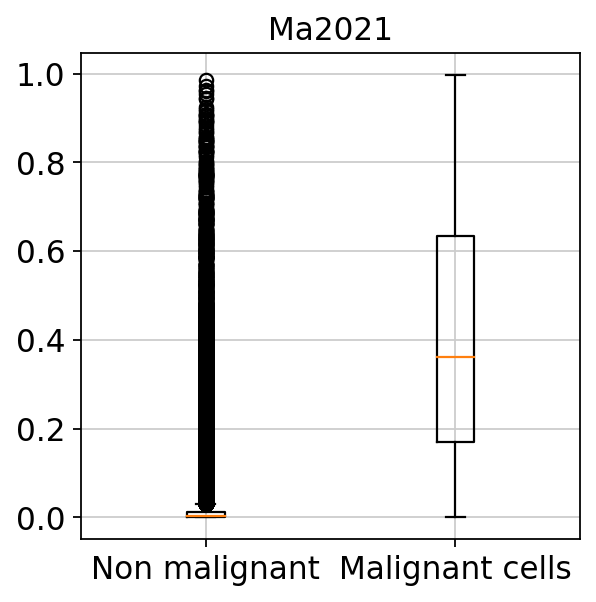

In [60]:
label = pd.read_csv("/home/glab/liver_atlas/Ma2021/Ma2021_cell_hECA.tsv", sep = '\t')
label['predict_malignancy'] = predict
label['type'][label['type'] != "Malignant cells"] = "Non malignant"
df = label[['type', 'predict_malignancy']]
df
import matplotlib.pyplot as plt
plt.rcParams["font.size"]=10#设置字体大小
plt.boxplot([df.predict_malignancy[df.type=='Non malignant'], df.predict_malignancy[df.type=='Malignant cells']],labels=['Non malignant', 'Malignant cells'])
plt.title('Ma2021')
plt.show()

# 10X samples-unimodal CNV score

In [105]:
epthelial_markers = ['EPCAM', 'GPC3', 'SPINK1', 'AKR1B10', 'KRT19', 'ALB', 'CYP2E1']

In [113]:
path = './SingleCell/20200215-HCC-Pt13c-Tumor'
print(path)
data = sc.read_10x_mtx(path+'/filtered_feature_bc_matrix', var_names='gene_symbols', cache=False)

./SingleCell/20200215-HCC-Pt13c-Tumor
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [107]:
genes = pd.read_csv(path+'/filtered_feature_bc_matrix/features.tsv.gz',sep = '\t', compression='gzip', header = None)

In [114]:
cellAnn = pd.read_csv(path +'/cellAnnotation.txt', delim_whitespace=True, 
                                  usecols=['barcodes','UMAP_1', 'UMAP_2', 'Malign.type', 'Epithelial.corr', 'Cell.Type'], index_col=['barcodes'])
    # h5ad files
    # data = sc.read_h5ad('../../lxq/PDAC/dynamics/PDAC/P4_seurat2scanpy.h5ad')
    # data = sc.read_h5ad('./CHOL/malig_choose.h5ad')

data.var_names_make_unique()
    # 基础过滤:去除表达基因200以下的细胞, 去除在3个细胞以下表达的基因。
    # sc.pp.filter_cells(data, min_genes=200)
sc.pp.filter_genes(data, min_cells=3)
    # 过滤线粒体基因比例 > 15% 的细胞
mito_genes = data.var_names.str.startswith('MT-')
data.obs['percent_mito'] = np.sum(data[:,mito_genes].X,axis=1).A1 / np.sum(data.X,axis=1).A1
data.obs['n_counts'] = data.X.sum(axis=1).A1
mitoThres = 0.15
    # data = data[data.obs.percent_mito < mitoThres, :]
data = data[cellAnn.index + '-1',]
    # 标准化:TPM
sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)
sc.pp.regress_out(data, ['n_counts', 'percent_mito']) # 校正细胞基因计数和线粒体基因比例的影响。
print("finish regressing...!!!")

filtered out 16449 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


/home/glab/wguo/softwares/anaconda3/envs/rtest4-3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:01:34)
finish regressing...!!!


In [115]:
# 整理数据
cntMatrix = sparse.csr_matrix(data.X).todense()
cellName = np.array(data.obs.index)
for i in range(len(cellName)):
    newName = cellName[i].split('-')[0]
    cellName[i] = newName
arr = pd.DataFrame(data=cntMatrix, index=cellName, columns=data.var.index)
    
selectGene = pd.read_csv('./txtData/genes-scRNA-tcga-sorted.txt', sep='\t', index_col=0)
arr = arr.loc[:,selectGene['0']]
sc.tl.tsne(data)
sc.pp.neighbors(data)
sc.tl.umap(data)
    # path = './SingleCell/' + predictSample
    # cellAnn = pd.read_csv(path+'/cellAnnotation.txt', delim_whitespace=True, 
    #                     usecols=['barcodes','tSNE_1','tSNE_2'], index_col=['barcodes'])
    # decomp_data = pd.merge(arr, cellAnn, how='inner', left_index=True, right_index=True)
    # predict = reg.predict(decomp_data.iloc[:,:-2])
    # decomp_data = decomp_data.loc[:,['tSNE_1','tSNE_2']]
print("finish umap...!!!")
THRESHOLD = 0.5
predictSample = name
predict = reg.predict(arr)

computing tSNE
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:01:15)
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:02:10)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)
finish umap...!!!


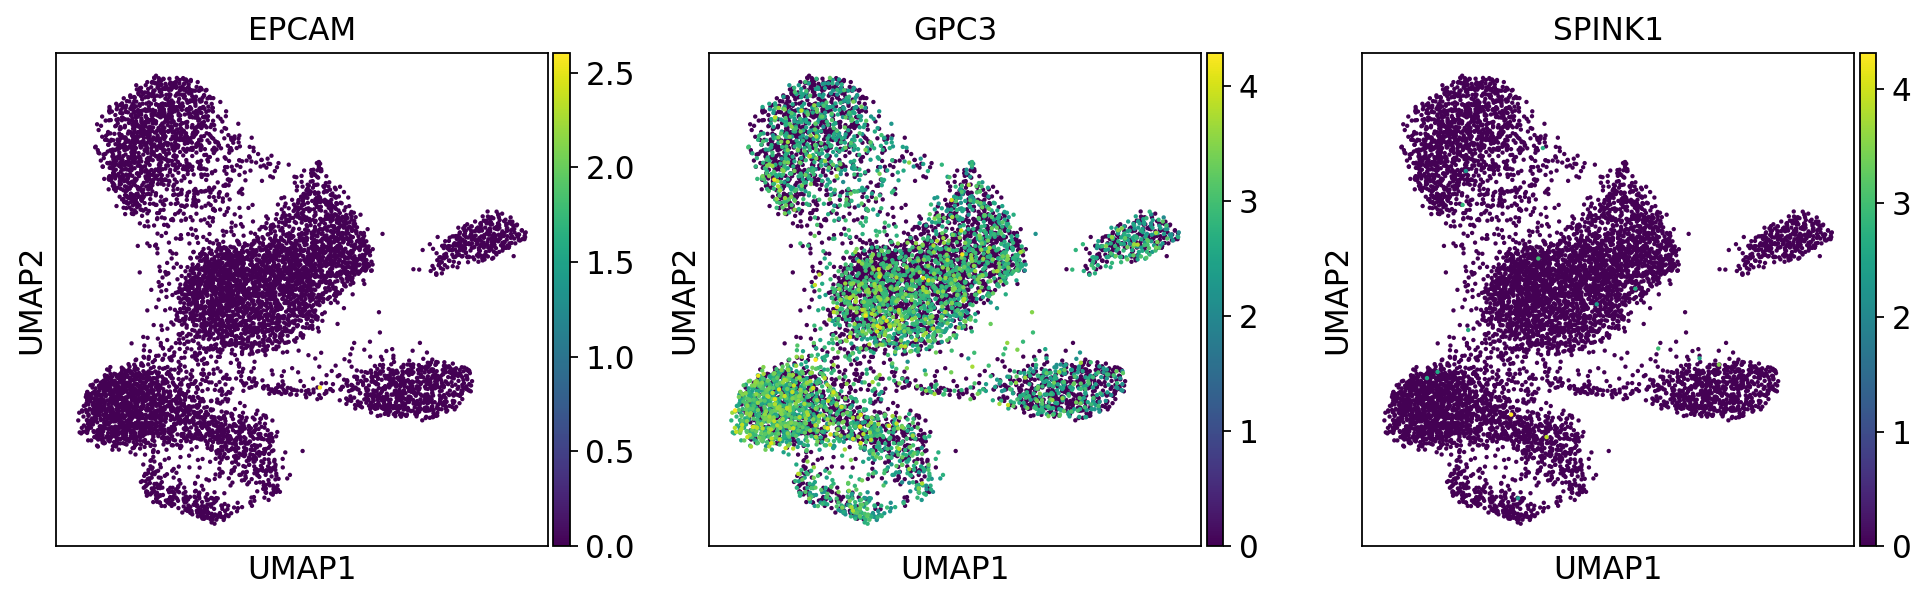

In [110]:
sc.pl.umap(data, color=epthelial_markers)

In [132]:
cellAnn.index = cellAnn.index + '-1'
cellAnn['Epithelial.corr']

barcodes
AAACCTGAGACCGGAT-1    0.151942
AAACCTGAGAGTACAT-1    0.114838
AAACCTGAGGCTCAGA-1    0.115326
AAACCTGAGTTCGCAT-1    0.081873
AAACCTGCAATTGCTG-1    0.075766
                        ...   
TTTGTCATCCTCATTA-1    0.092334
TTTGTCATCGAGAGCA-1    0.101545
TTTGTCATCGTTGACA-1    0.114064
TTTGTCATCTAGCACA-1    0.085529
TTTGTCATCTGGTATG-1    0.090849
Name: Epithelial.corr, Length: 7770, dtype: float64

In [135]:
predict = predict > THRESHOLD
data.obs['malignancy'] = predict
data.obs['Epithelial.corr'] = cellAnn['Epithelial.corr']
data.obs['Cell.Type'] = cellAnn['Cell.Type']
data.obs

percent_mito  n_counts  malignancy  Epithelial.corr  \
AAACCTGAGACCGGAT-1      0.327971    1119.0        True         0.151942   
AAACCTGAGAGTACAT-1      0.515640    1055.0       False         0.114838   
AAACCTGAGGCTCAGA-1      0.421795     780.0        True         0.115326   
AAACCTGAGTTCGCAT-1      0.417745     541.0       False         0.081873   
AAACCTGCAATTGCTG-1      0.431542     577.0       False         0.075766   
...                          ...       ...         ...              ...   
TTTGTCATCCTCATTA-1      0.370317     694.0       False         0.092334   
TTTGTCATCGAGAGCA-1      0.362565     764.0       False         0.101545   
TTTGTCATCGTTGACA-1      0.296024     679.0       False         0.114064   
TTTGTCATCTAGCACA-1      0.431818     616.0       False         0.085529   
TTTGTCATCTGGTATG-1      0.365159     597.0       False         0.090849   

                      Cell.Type  
AAACCTGAGACCGGAT-1   Epithelial  
AAACCTGAGAGTACAT-1  T.cells.CD8  
AAACCTGAGGCTCAGA-1   Epithelial  
AAACCTGAGTTCGCAT-1      Unknown  
AAACCTGCAATTGCTG-1  T.cells.CD4  
...                         ...  
TTTGTCATCCTCATTA-1      B.cells  
TTTGTCATCGAGAGCA-1   Epithelial  
TTTGTCATCGTTGACA-1   Epithelial  
TTTGTCATCTAGCACA-1      Unknown  
TTTGTCATCTGGTATG-1  T.cells.CD4  

[7770 rows x 5 columns]

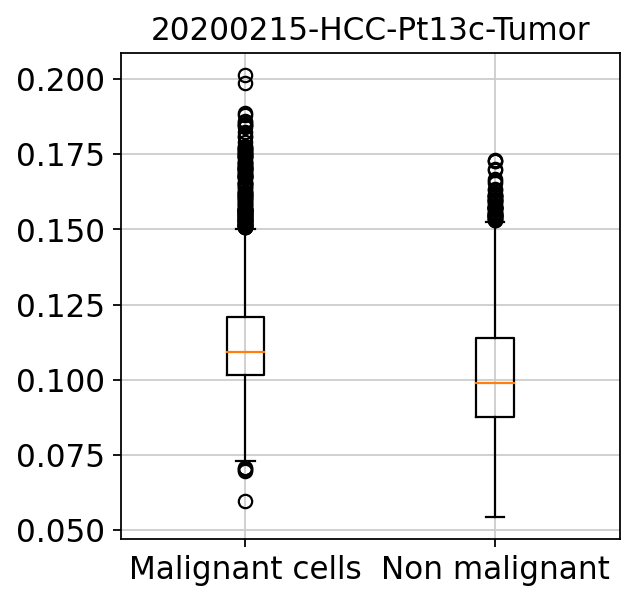

In [134]:
plt.boxplot([data.obs['Epithelial.corr'][data.obs['malignancy']==True], data.obs['Epithelial.corr'][data.obs['malignancy']==False]],
            labels=['Malignant cells', 'Non malignant'])
plt.title('20200215-HCC-Pt13c-Tumor')
plt.show()

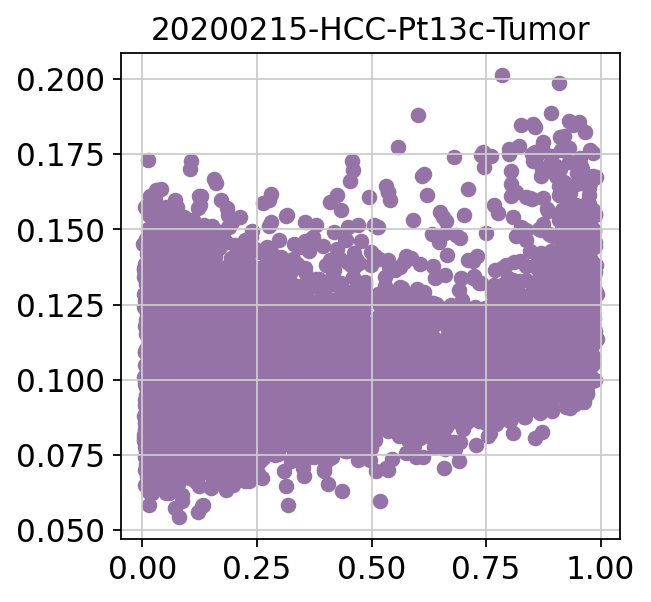

In [125]:
plt.scatter(data.obs['malignancy'], data.obs['Epithelial.corr'], color='#9673A6')
plt.title('20200215-HCC-Pt13c-Tumor')
plt.show()

./SingleCell/20200217-LUAD-LX653-Tumor
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
filtered out 14881 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:36)
finish regressing...!!!
computing tSNE
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:11)
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:13)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
finish uma

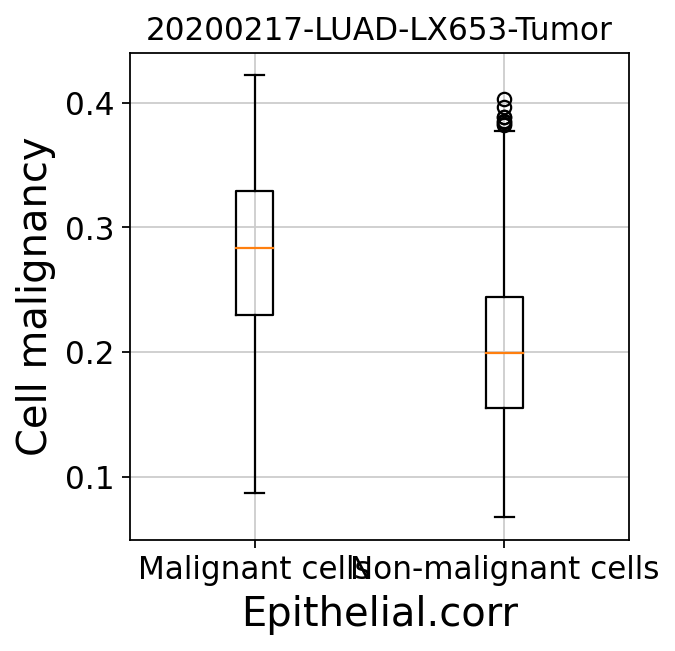

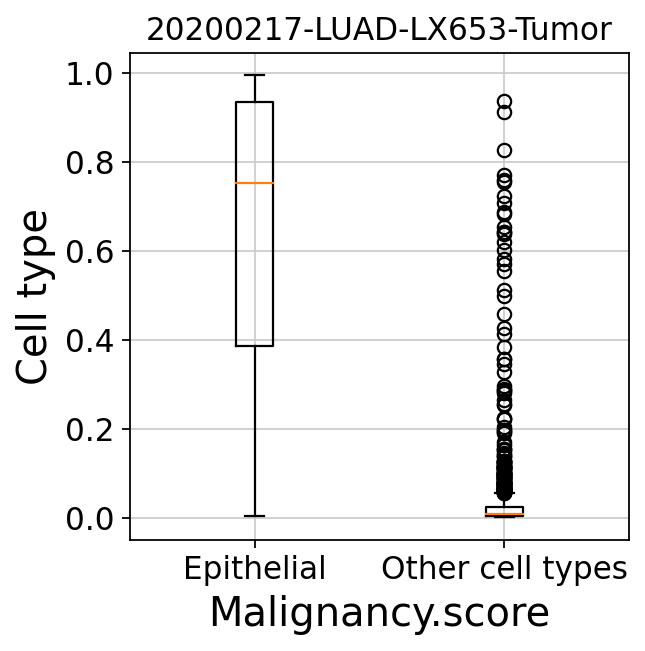

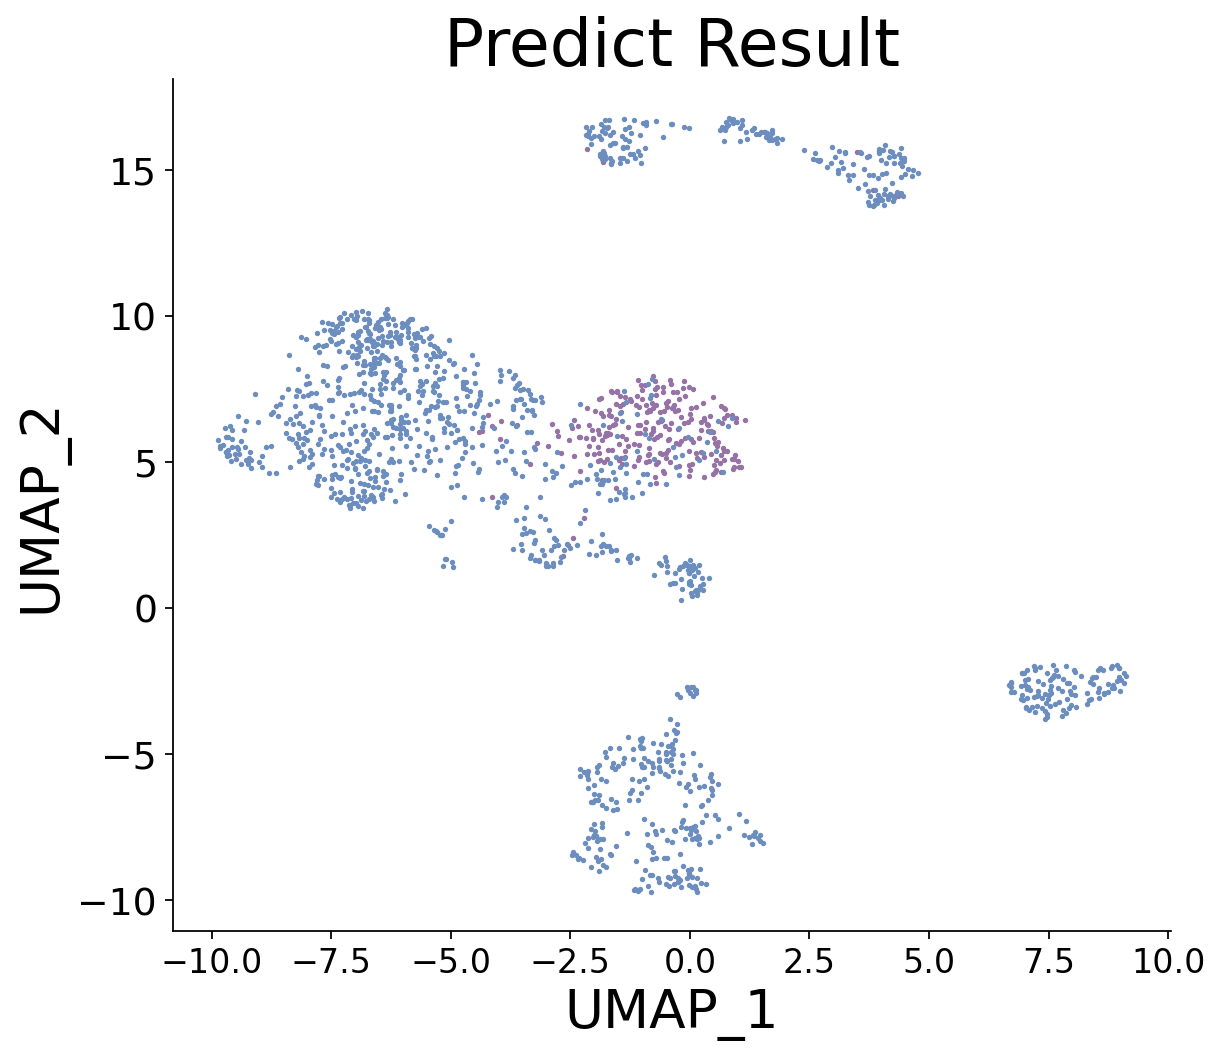

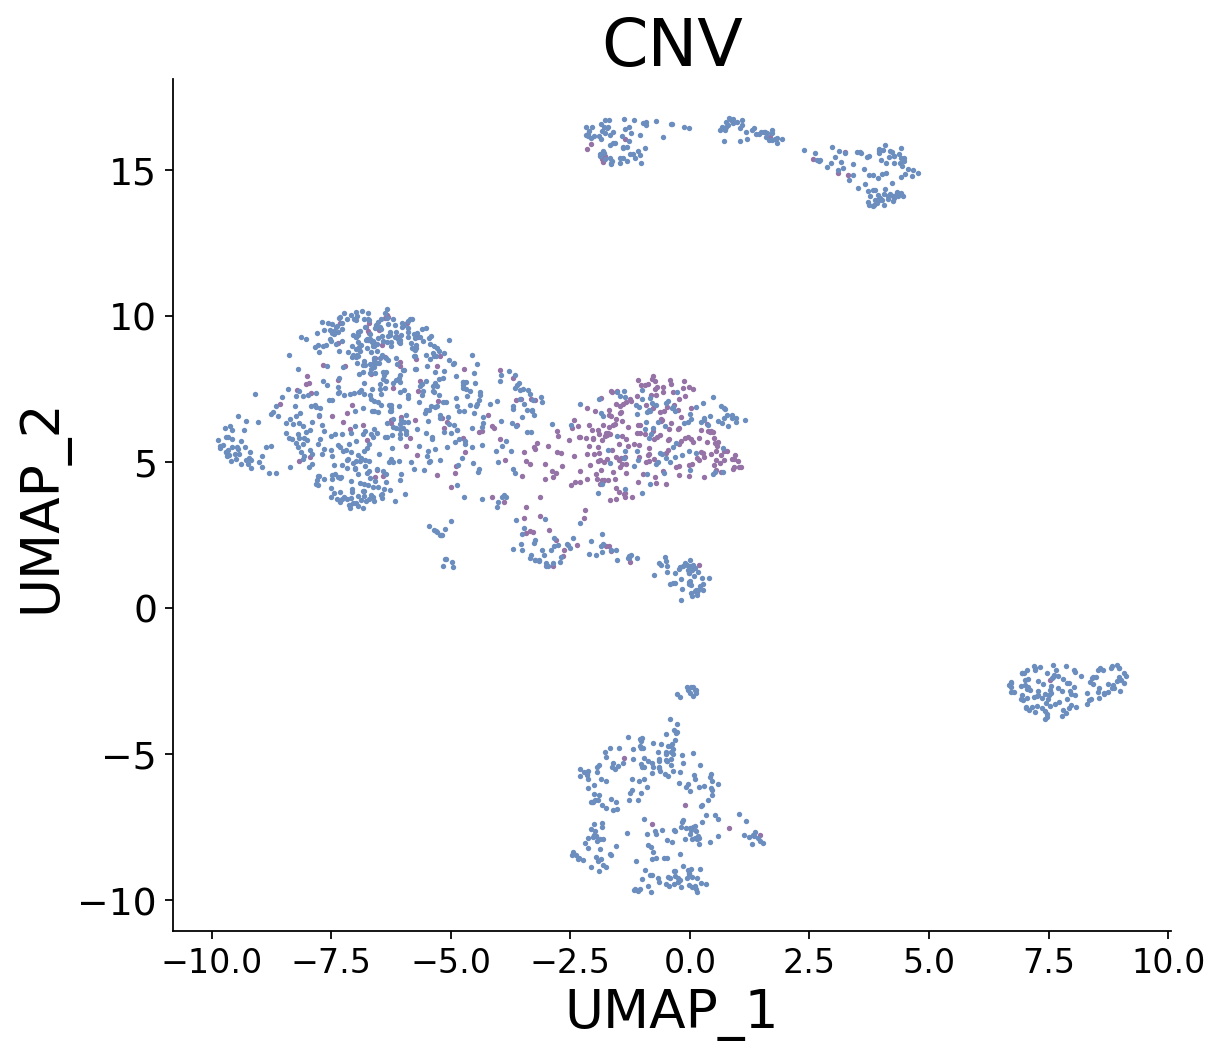

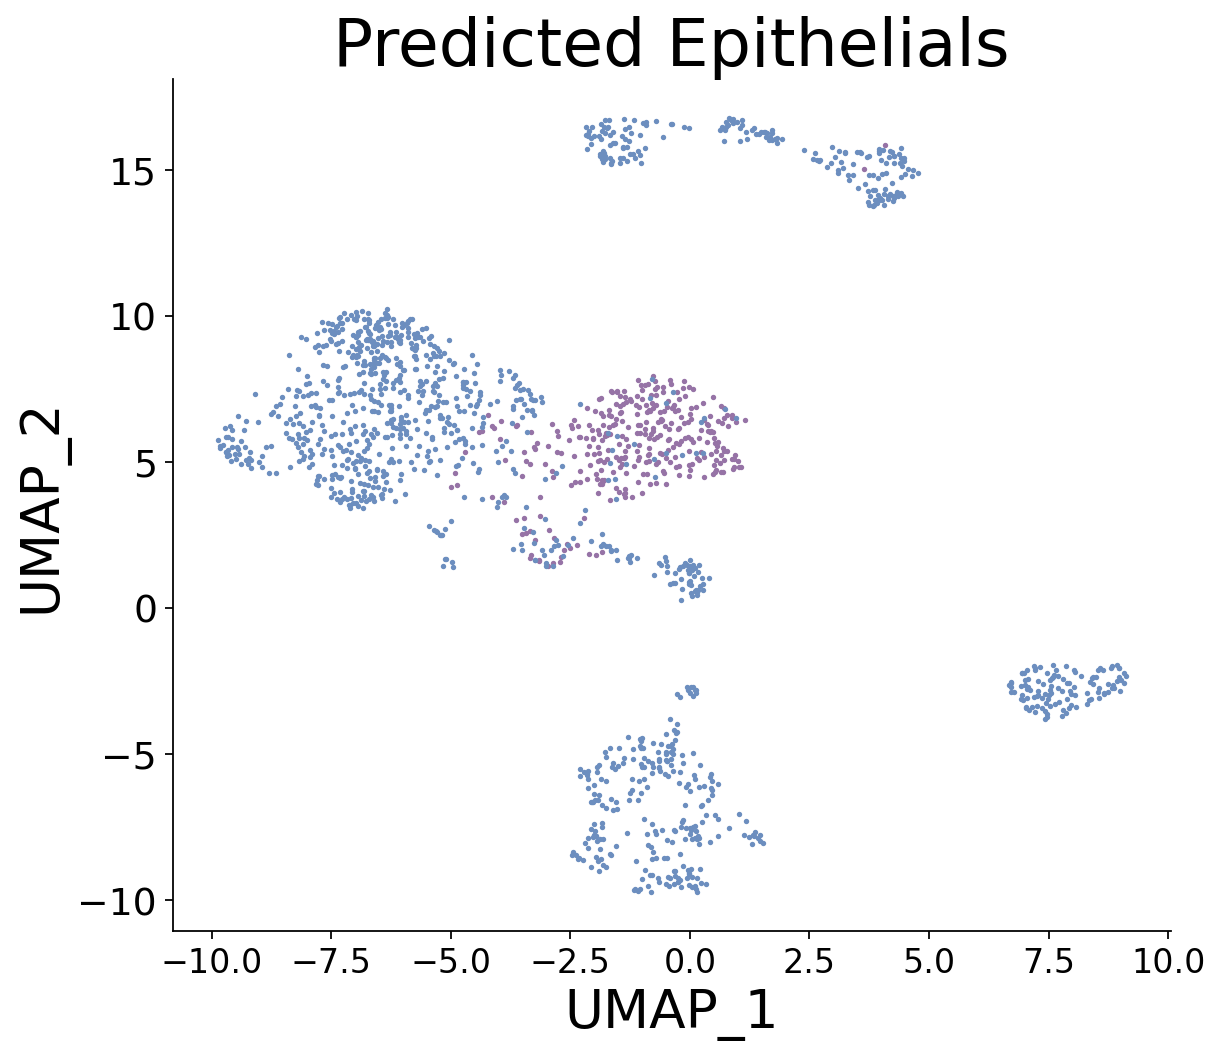

In [13]:
# Samples selected
names = ['20200217-LUAD-LX653-Tumor', '20200208-PAC-CRR034496-T1-Tumor', '20200215-HCC-Pt13c-Tumor',
         '20200217-LUAD-LX684-Tumor', '20200215-HCC-Pt14d-Tumor','20200208-PAC-CRR034505-T10-Tumor']
for name in names:
    path = './SingleCell/' + name
    print(path)
    data = sc.read_10x_mtx(path+'/filtered_feature_bc_matrix', var_names='gene_symbols', cache=False)
    cellAnn = pd.read_csv(path +'/cellAnnotation.txt', delim_whitespace=True, 
                          usecols=['barcodes','UMAP_1', 'UMAP_2', 'Malign.type', 'Epithelial.corr', 'Cell.Type'],
                          index_col=['barcodes'])
    # h5ad files
    # data = sc.read_h5ad('../../lxq/PDAC/dynamics/PDAC/P4_seurat2scanpy.h5ad')
    # data = sc.read_h5ad('./CHOL/malig_choose.h5ad')

    data.var_names_make_unique()
    # 基础过滤:去除表达基因200以下的细胞, 去除在3个细胞以下表达的基因。
    # sc.pp.filter_cells(data, min_genes=200)
    sc.pp.filter_genes(data, min_cells=3)
    # 过滤线粒体基因比例 > 15% 的细胞
    mito_genes = data.var_names.str.startswith('MT-')
    data.obs['percent_mito'] = np.sum(data[:,mito_genes].X,axis=1).A1 / np.sum(data.X,axis=1).A1
    data.obs['n_counts'] = data.X.sum(axis=1).A1
    mitoThres = 0.15
    # data = data[data.obs.percent_mito < mitoThres, :]
    data = data[cellAnn.index + '-1',]
    # 标准化:TPM
    sc.pp.normalize_total(data, target_sum=1e4)
    sc.pp.log1p(data)
    sc.pp.regress_out(data, ['n_counts', 'percent_mito']) # 校正细胞基因计数和线粒体基因比例的影响。
    print("finish regressing...!!!")
    # 整理数据
    cntMatrix = sparse.csr_matrix(data.X).todense()
    cellName = np.array(data.obs.index)
    for i in range(len(cellName)):
        newName = cellName[i].split('-')[0]
        cellName[i] = newName
    arr = pd.DataFrame(data=cntMatrix, index=cellName, columns=data.var.index)
    
    selectGene = pd.read_csv('./txtData/genes-scRNA-tcga-sorted.txt', sep='\t', index_col=0)
    arr = arr.loc[:,selectGene['0']]
    sc.tl.tsne(data)
    sc.pp.neighbors(data)
    sc.tl.umap(data)
    # path = './SingleCell/' + predictSample
    # cellAnn = pd.read_csv(path+'/cellAnnotation.txt', delim_whitespace=True, 
    #                     usecols=['barcodes','tSNE_1','tSNE_2'], index_col=['barcodes'])
    # decomp_data = pd.merge(arr, cellAnn, how='inner', left_index=True, right_index=True)
    # predict = reg.predict(decomp_data.iloc[:,:-2])
    # decomp_data = decomp_data.loc[:,['tSNE_1','tSNE_2']]
    print("finish umap...!!!")
    THRESHOLD = 0.5
    predictSample = name
    predict = reg.predict(arr)
    data.obs['malignancy.score'] = predict
    predict = predict > THRESHOLD
    data.obs['malignant.label'] = predict
    cellAnn.index = cellAnn.index + '-1'
    data.obs['Epithelial.corr'] = cellAnn['Epithelial.corr']
    data.obs['Cell.Type'] = cellAnn['Cell.Type']
    plt.boxplot([data.obs['Epithelial.corr'][data.obs['malignant.label']==True], data.obs['Epithelial.corr'][data.obs['malignant.label']==False]],
            labels=['Malignant cells', 'Non-malignant cells'])
    plt.xlabel('Epithelial.corr', fontsize = 18)
    plt.ylabel('Cell malignancy', fontsize = 18)
    plt.title(name)
    plt.show()
    
    plt.boxplot([data.obs['malignancy.score'][data.obs['Cell.Type']=="Epithelial"],
                 data.obs['malignancy.score'][data.obs['Cell.Type']!="Epithelial"]],
                labels=['Epithelial', 'Other cell types'])
    plt.xlabel('Malignancy.score', fontsize = 18)
    plt.ylabel('Cell type', fontsize = 18)
    plt.title(name)
    plt.show()
    
    # decomp_data = data.obsm['X_tsne']
    decomp_data = data.obsm['X_umap']
    pred_true_idx  = predict == 1
    pred_false_idx = predict == 0

    ALPHA = 1
    S = 2
    path = './Predict/'
    plt.figure(1, figsize=(8,7))
    plt.grid(b=False)
    plt.scatter(x=decomp_data[pred_true_idx,0] ,y=decomp_data[pred_true_idx,1] ,c='#9673A6',s=S,label='Malignant',alpha=ALPHA)
    plt.scatter(x=decomp_data[pred_false_idx,0],y=decomp_data[pred_false_idx,1],c='#6C8EBF',s=S,label='nonMalignant',alpha=ALPHA)
    # plt.legend(loc='upper left', fontsize = 15)
    # plt.xlabel('tSNE_1')
    # plt.ylabel('tSNE_2')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=17)
    plt.xlabel('UMAP_1', fontsize=24)
    plt.ylabel('UMAP_2', fontsize=24)
    plt.title('Predict Result', fontsize=30)
        
    ax = plt.gca()
    ax.spines.right.set_color('none')
    ax.spines['top'].set_visible(False)
    plt.savefig(path+predictSample+'.jpg', dpi=100)
    plt.show()
    
    tag_true_idx = cellAnn['Malign.type'] == 'malignant'
    tag_false_idx = cellAnn['Malign.type'] == 'nonMalignant'
    plt.figure(2, figsize=(8,7))
    plt.grid(b=False)
    plt.scatter(x=decomp_data[tag_true_idx,0] ,y=decomp_data[tag_true_idx,1] ,c='#9673A6',s=S,label='Malignant',alpha=ALPHA)
    plt.scatter(x=decomp_data[tag_false_idx,0],y=decomp_data[tag_false_idx,1],c='#6C8EBF',s=S,label='nonMalignant',alpha=ALPHA)
    # plt.legend(loc='upper left', fontsize = 15)
    # plt.xlabel('tSNE_1')
    # plt.ylabel('tSNE_2')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=17)
    plt.xlabel('UMAP_1', fontsize=24)
    plt.ylabel('UMAP_2', fontsize=24)
    plt.title('CNV', fontsize=30) 
    ax = plt.gca()
    ax.spines.right.set_color('none')
    ax.spines['top'].set_visible(False)
    
    plt.savefig(path+predictSample+'-CNV.jpg', dpi=100)
    plt.show()
    
    tag_true_idx = cellAnn['Cell.Type'] == 'Epithelial'
    tag_false_idx = cellAnn['Cell.Type'] != 'Epithelial'
    plt.figure(3, figsize=(8,7))
    plt.grid(b=False)
    plt.scatter(x=decomp_data[tag_true_idx,0] ,y=decomp_data[tag_true_idx,1] ,c='#9673A6',s=S,label='Epithelial',alpha=ALPHA)
    plt.scatter(x=decomp_data[tag_false_idx,0],y=decomp_data[tag_false_idx,1],c='#6C8EBF',s=S,label='Others',alpha=ALPHA)
    # plt.legend(loc='upper left', fontsize = 15)
    # plt.xlabel('tSNE_1')
    # plt.ylabel('tSNE_2')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=17)
    plt.xlabel('UMAP_1', fontsize=24)
    plt.ylabel('UMAP_2', fontsize=24)
    plt.title('Predicted Epithelials', fontsize=30) 
    ax = plt.gca()
    ax.spines.right.set_color('none')
    ax.spines['top'].set_visible(False)
    plt.savefig(path+predictSample+'-Epithelial.jpg', dpi=100)
    plt.show()


# Plot markers

./SingleCell/20200217-LUAD-LX653-Tumor
... reading from cache file cache/SingleCell-20200217-LUAD-LX653-Tumor-filtered_feature_bc_matrix-matrix.h5ad
normalizing counts per cell
    finished (0:00:00)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


/home/glab/wguo/softwares/anaconda3/envs/rtest4-3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:41)
finish regressing...!!!
computing tSNE
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:21)
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:23)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
finish umap...!!!


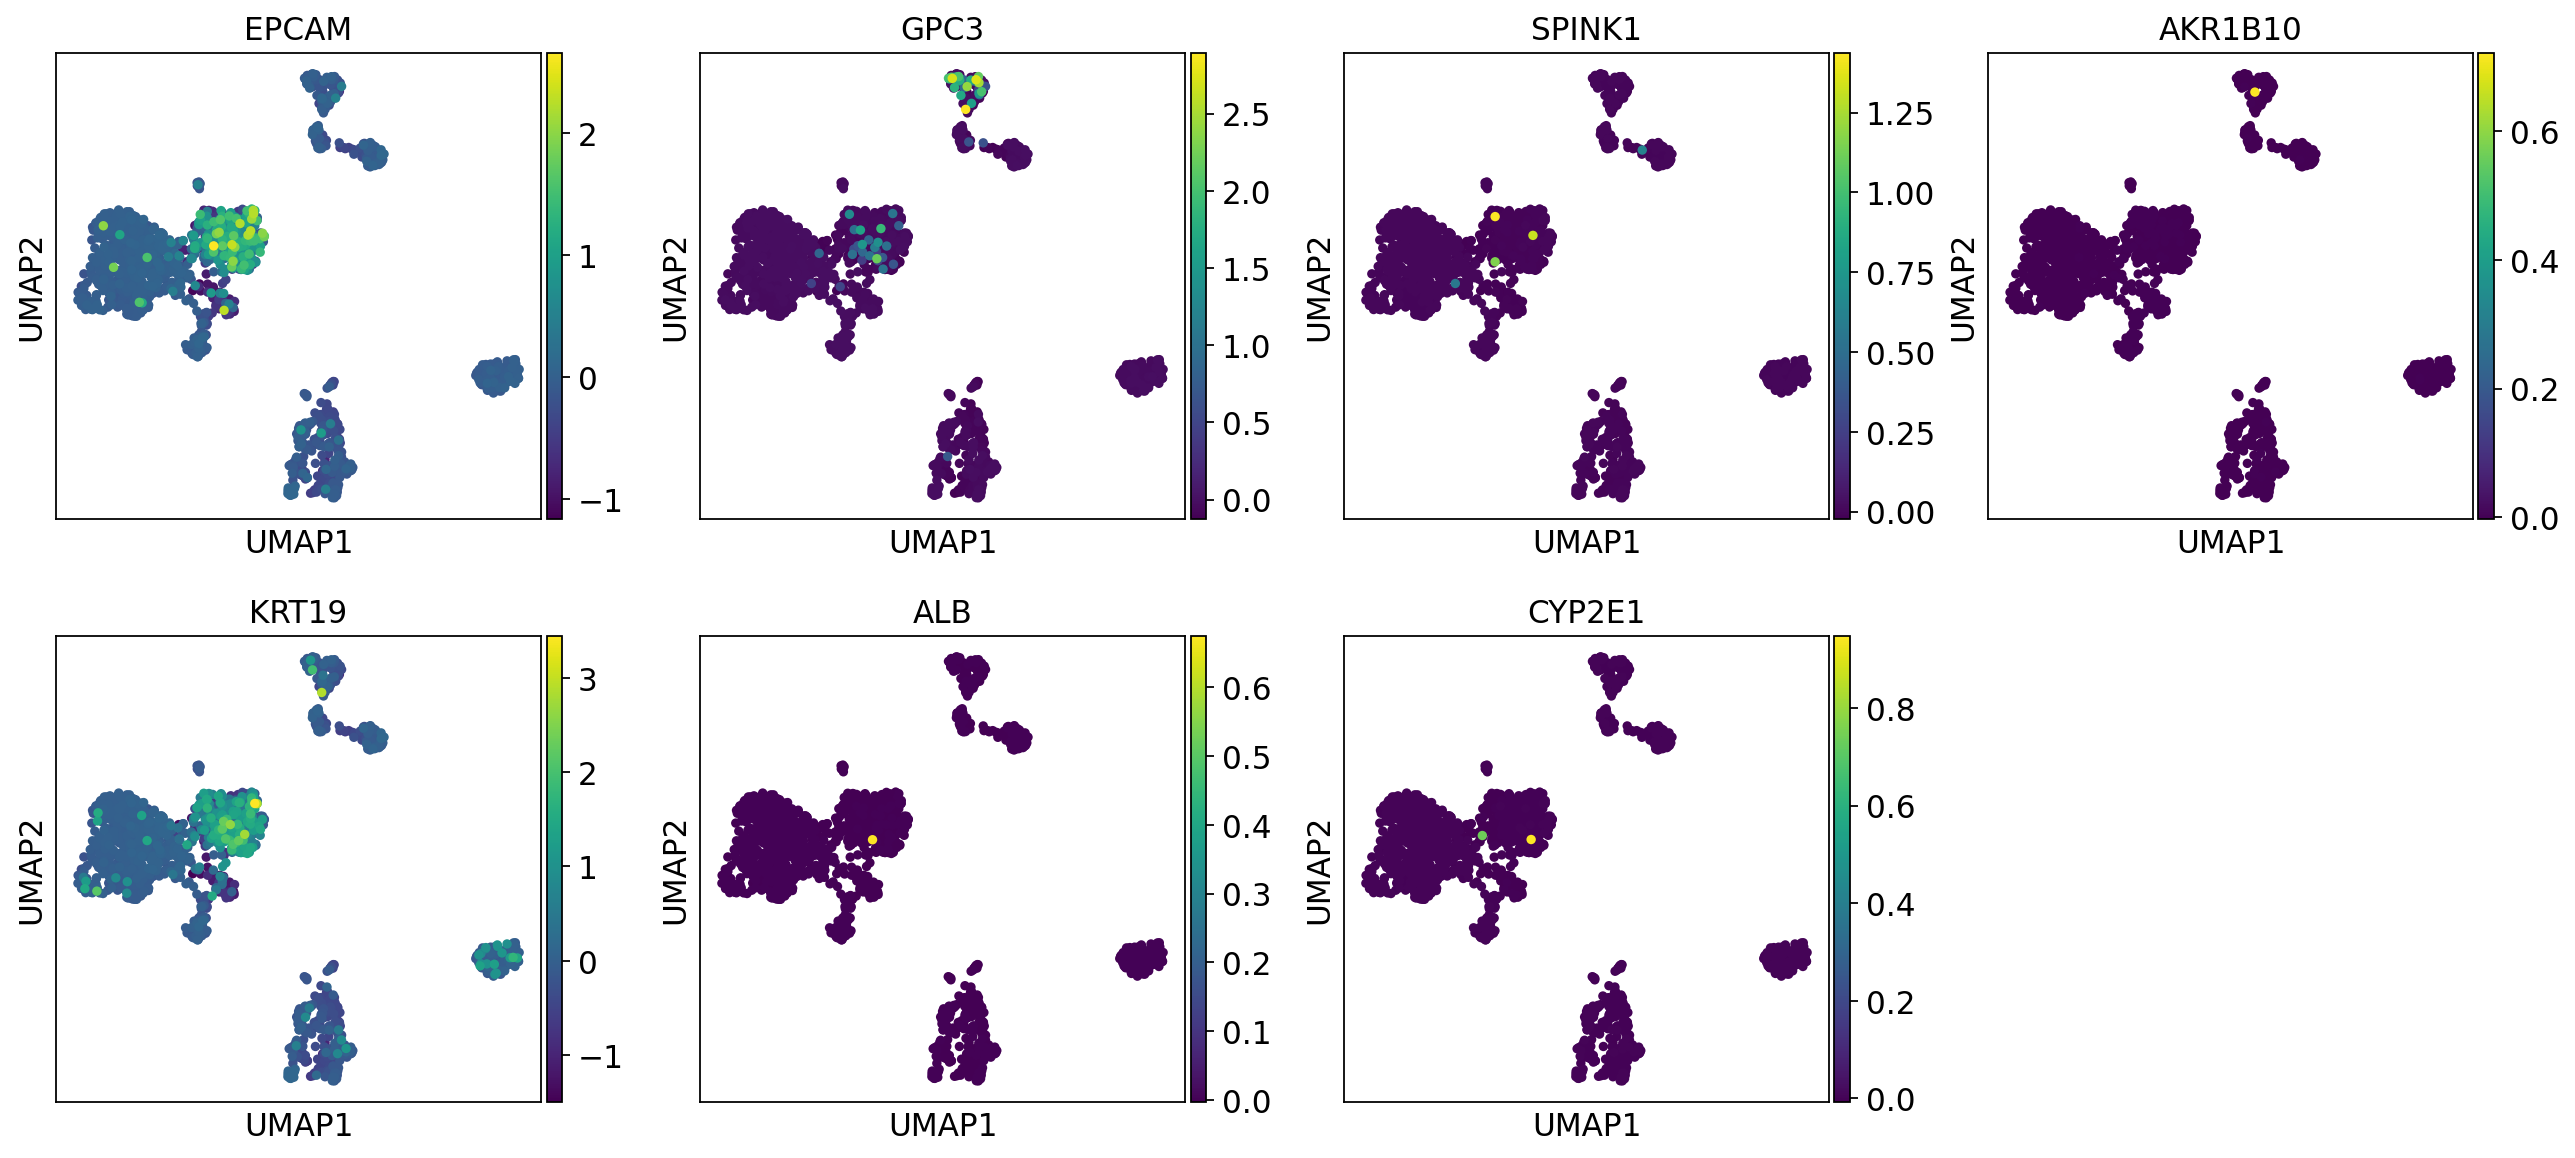

./SingleCell/20200208-PAC-CRR034496-T1-Tumor
... reading from cache file cache/SingleCell-20200208-PAC-CRR034496-T1-Tumor-filtered_feature_bc_matrix-matrix.h5ad
normalizing counts per cell
    finished (0:00:00)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


/home/glab/wguo/softwares/anaconda3/envs/rtest4-3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:44)
finish regressing...!!!
computing tSNE
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:27)
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:29)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
finish umap...!!!


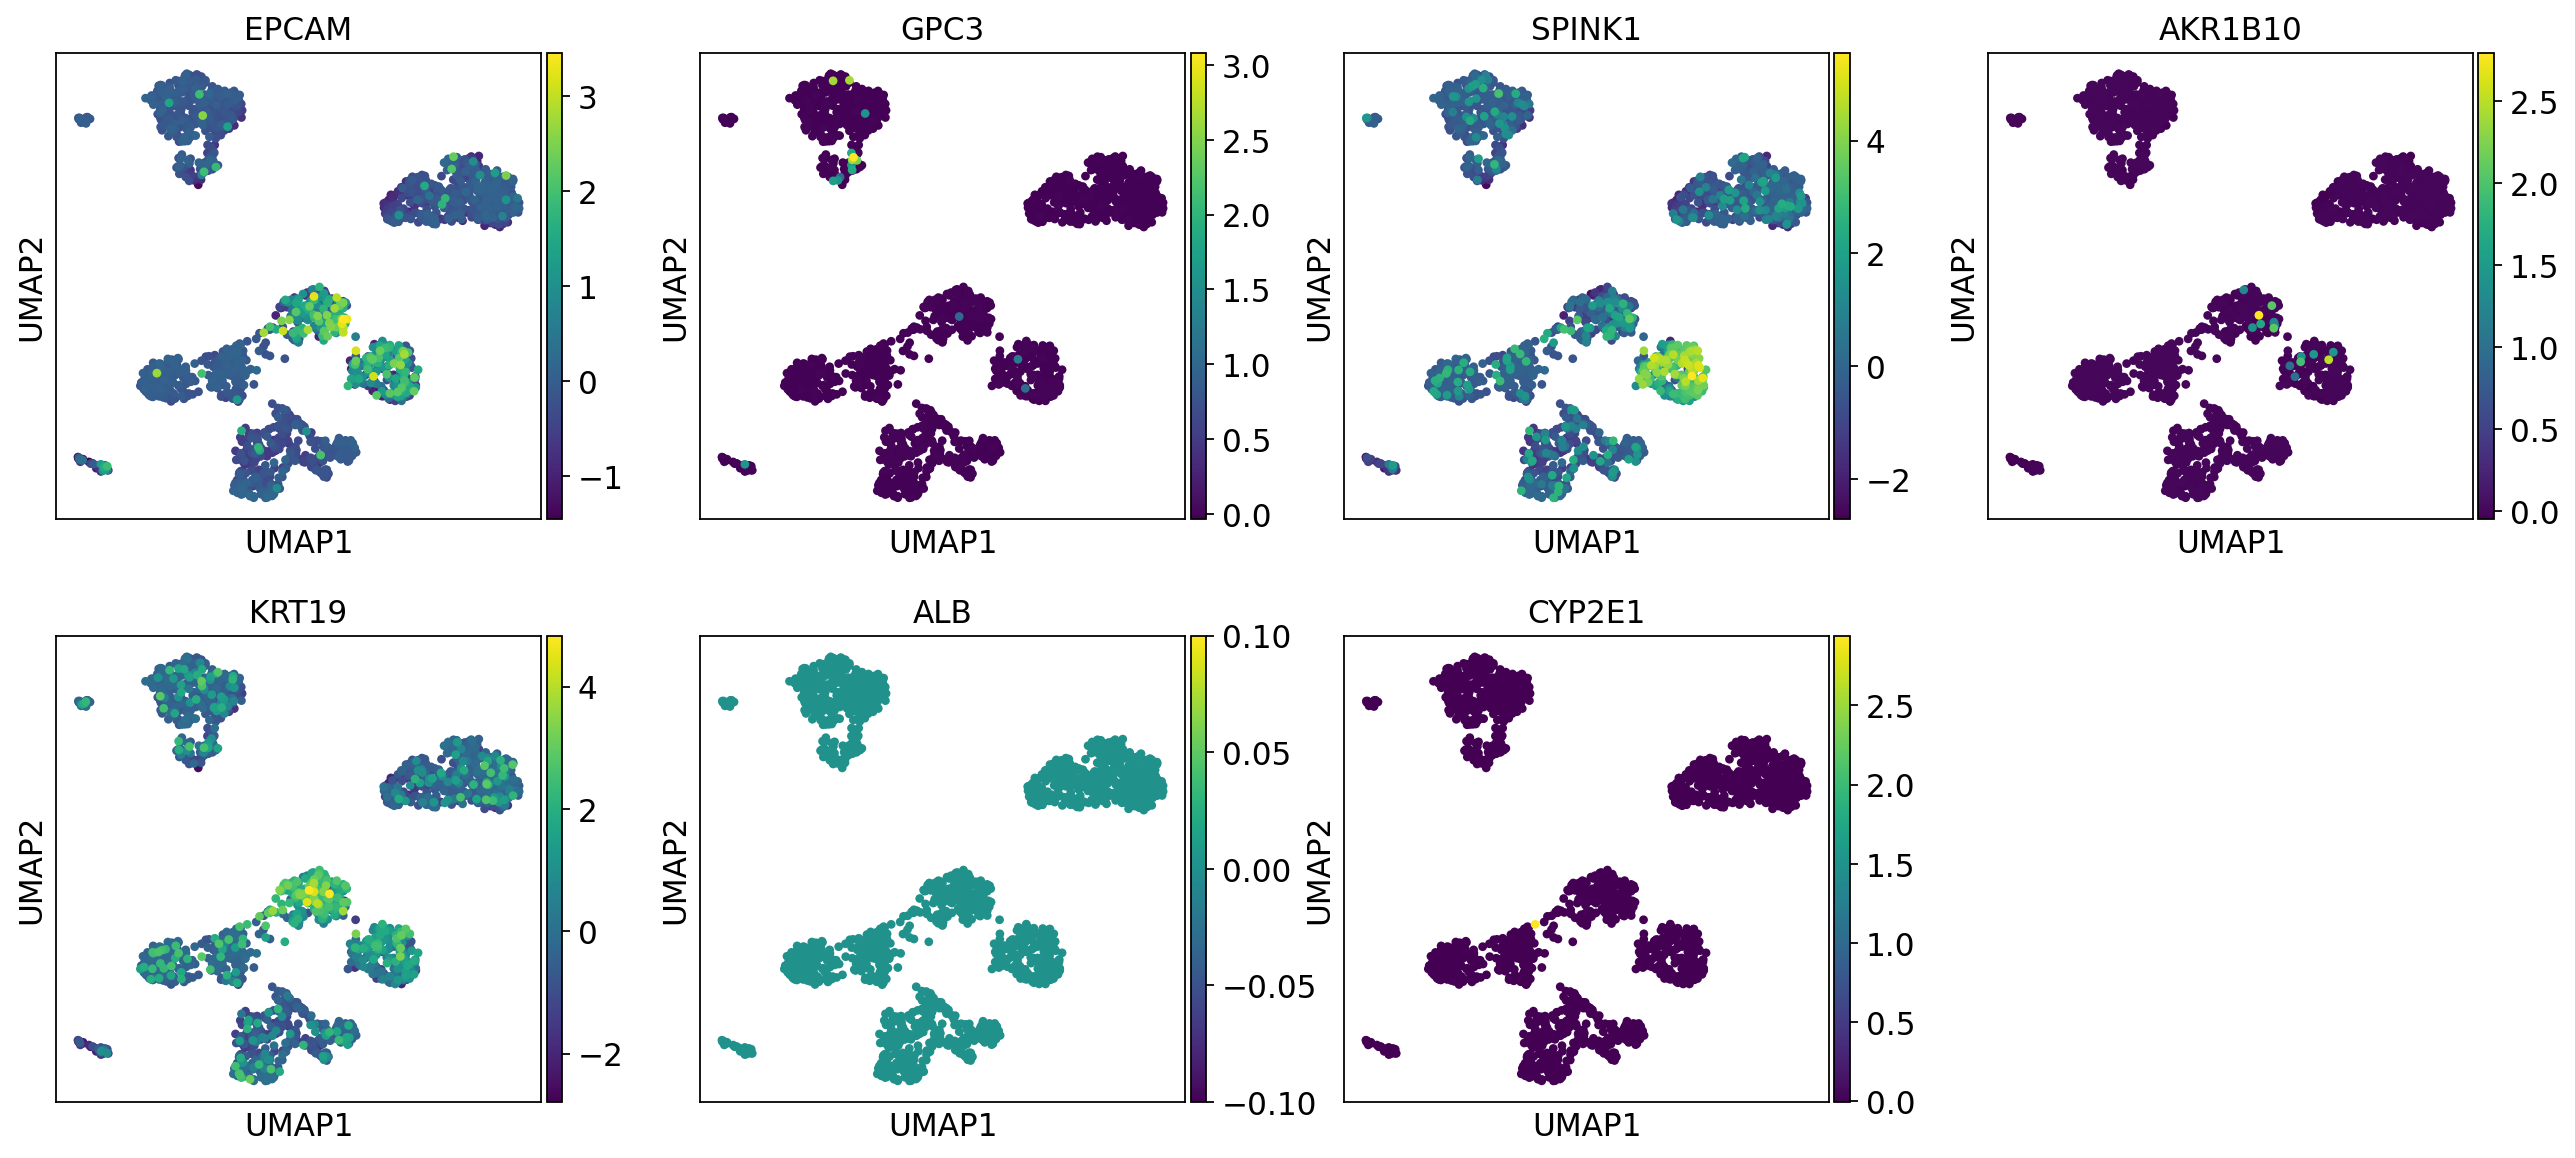

./SingleCell/20200215-HCC-Pt13c-Tumor
... reading from cache file cache/SingleCell-20200215-HCC-Pt13c-Tumor-filtered_feature_bc_matrix-matrix.h5ad
normalizing counts per cell
    finished (0:00:00)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


/home/glab/wguo/softwares/anaconda3/envs/rtest4-3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:01:55)
finish regressing...!!!
computing tSNE
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:02:13)
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:02:29)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)
finish umap...!!!


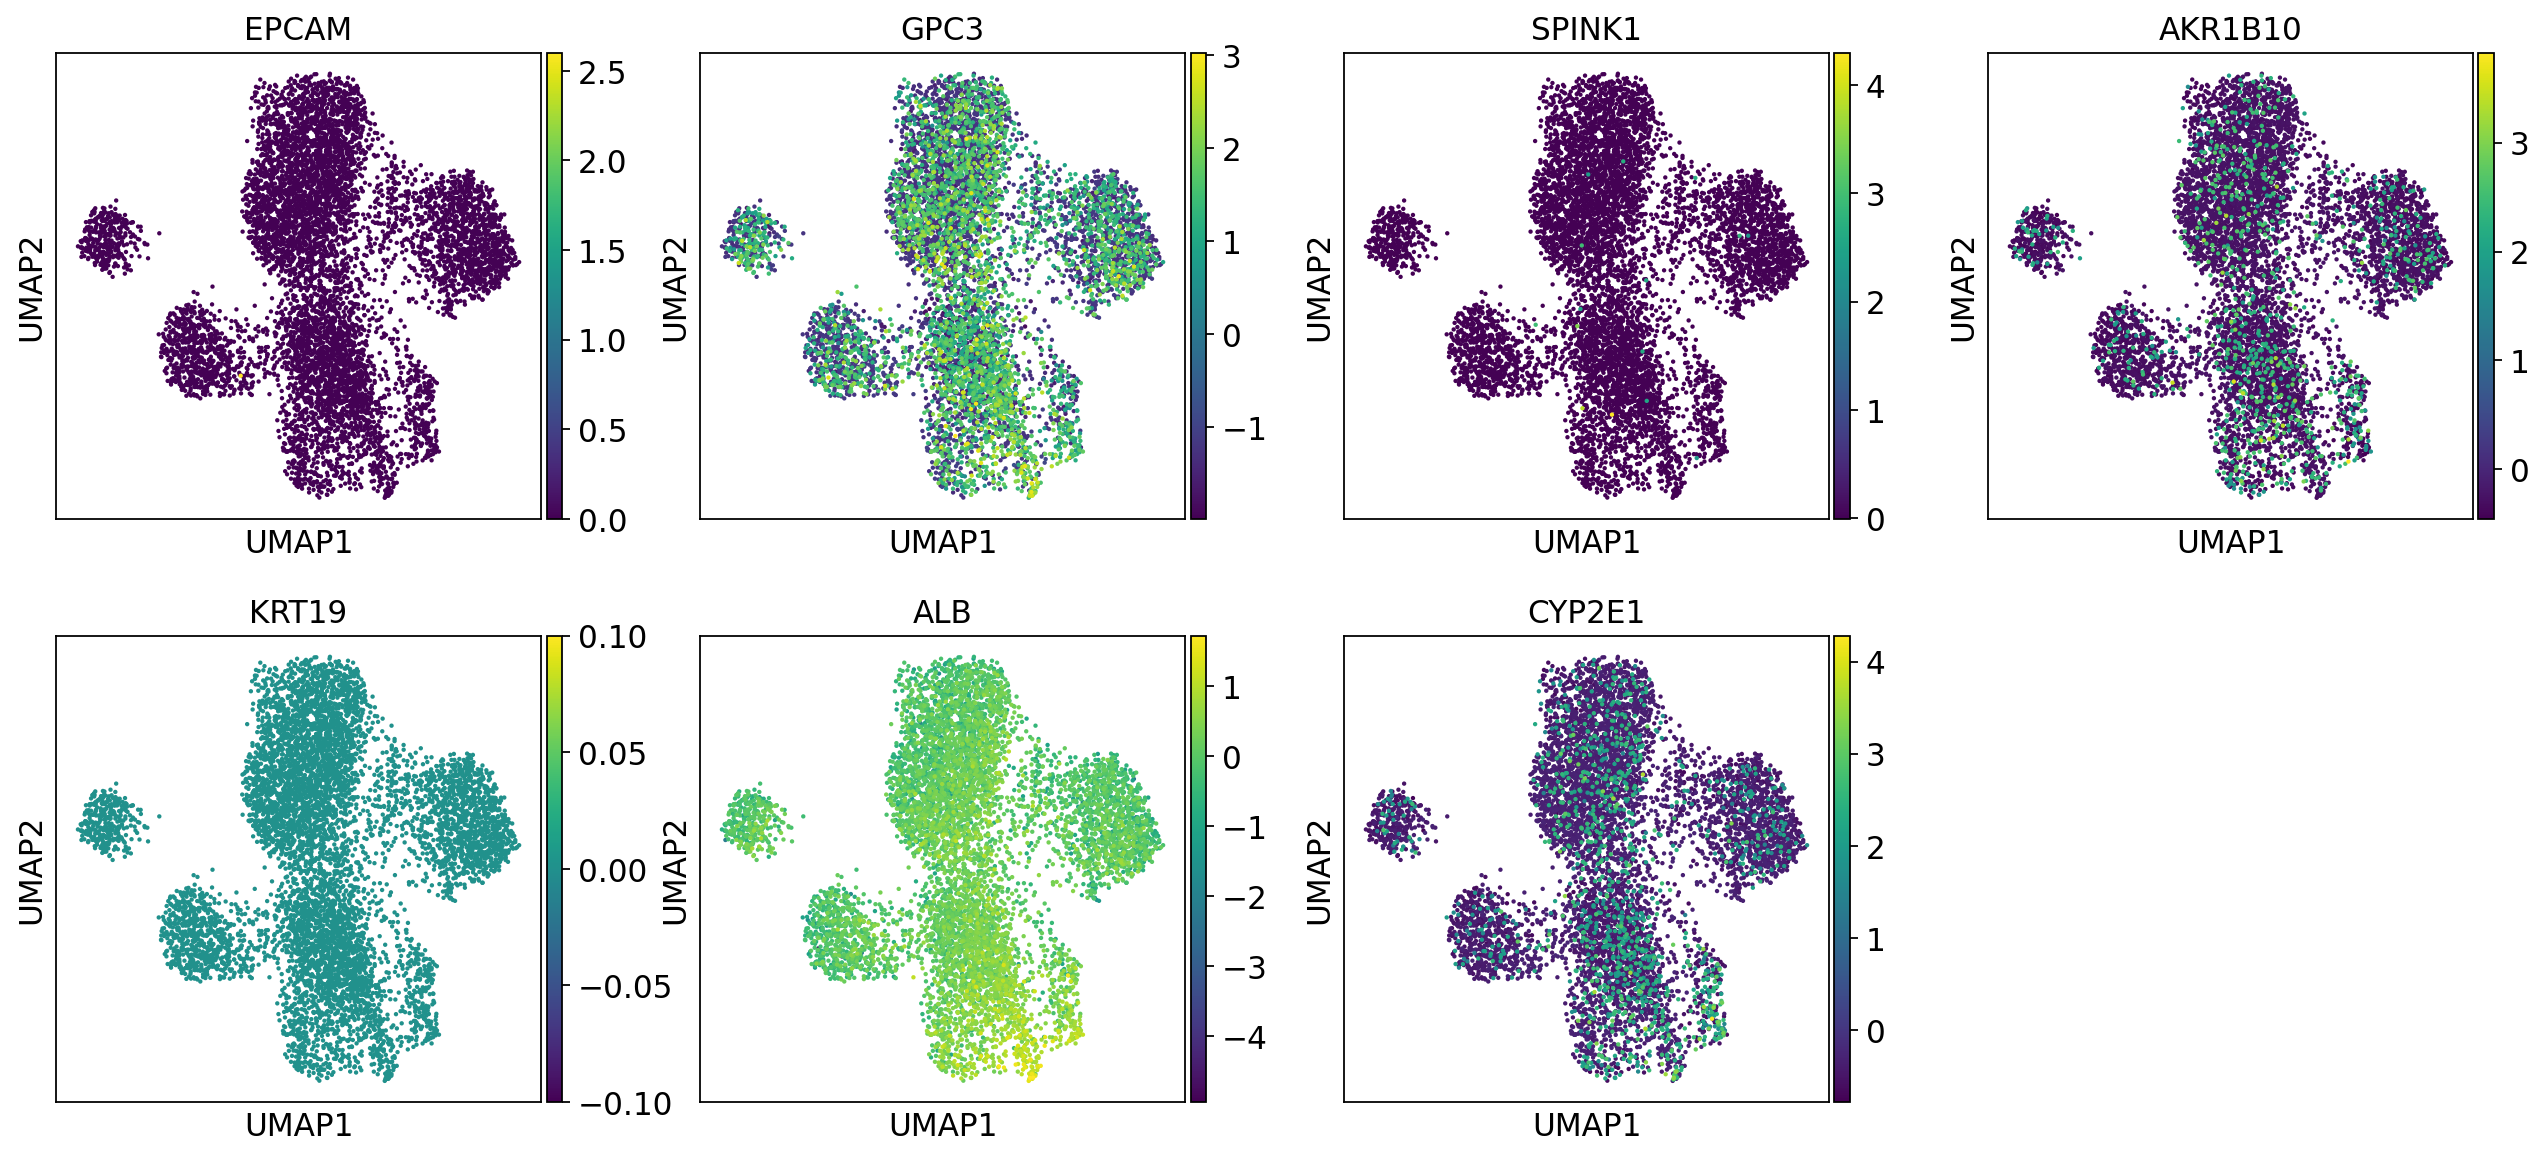

./SingleCell/20200217-LUAD-LX684-Tumor
... writing an h5ad cache file to speedup reading next time
normalizing counts per cell
    finished (0:00:00)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


/home/glab/wguo/softwares/anaconda3/envs/rtest4-3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:56)
finish regressing...!!!
computing tSNE
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:38)
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:41)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
finish umap...!!!


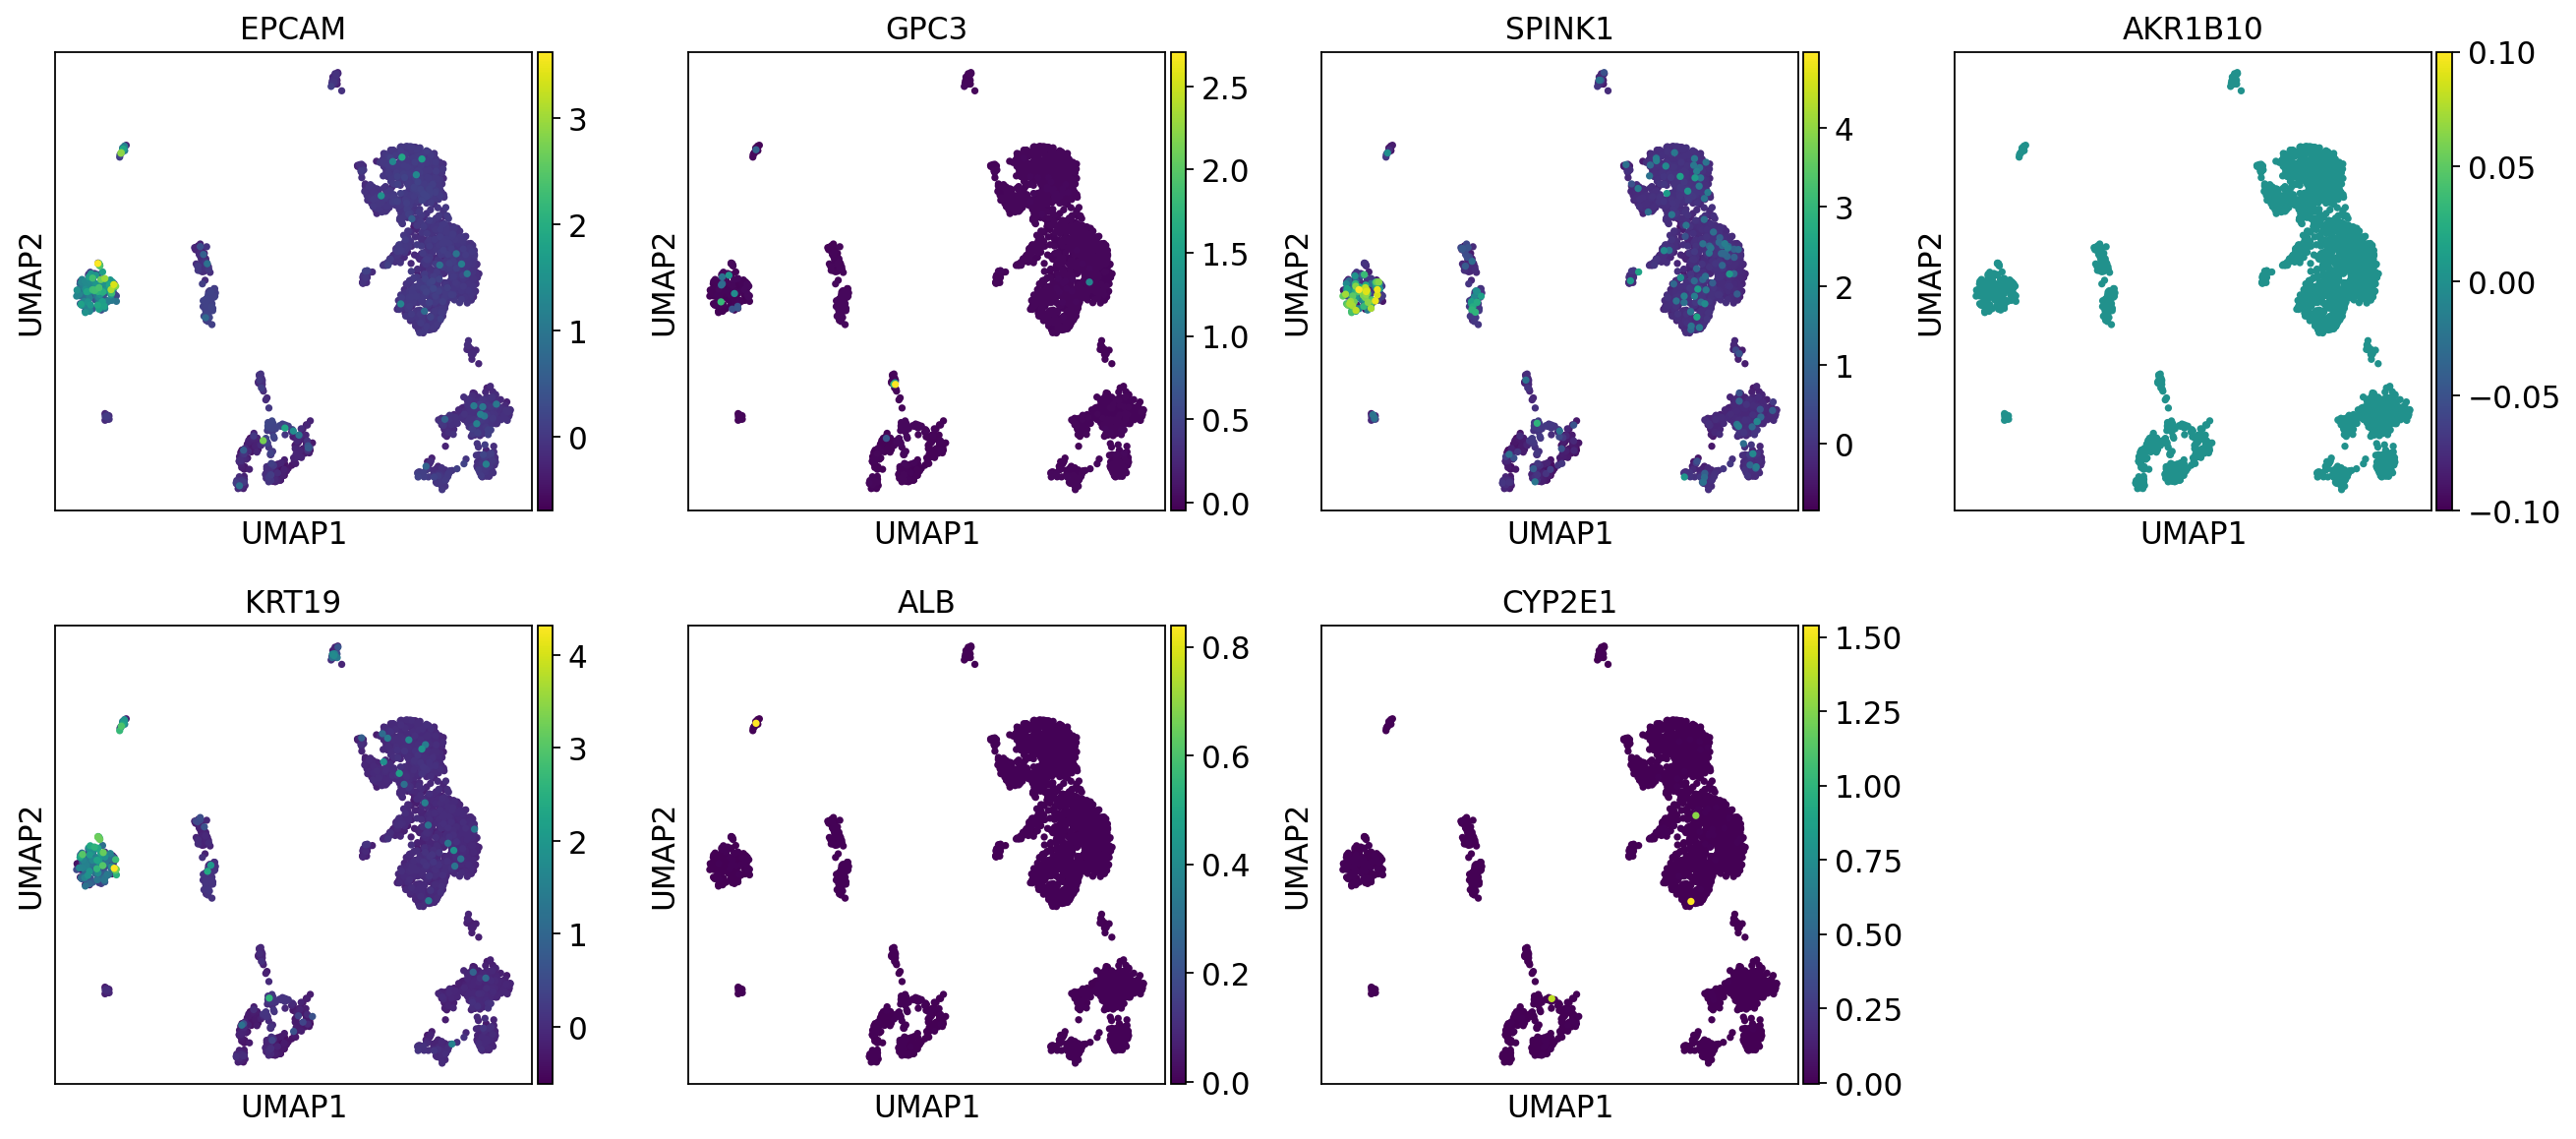

./SingleCell/20200215-HCC-Pt14d-Tumor
... reading from cache file cache/SingleCell-20200215-HCC-Pt14d-Tumor-filtered_feature_bc_matrix-matrix.h5ad
normalizing counts per cell
    finished (0:00:00)


/home/glab/wguo/softwares/anaconda3/envs/rtest4-3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:06:07)
finish regressing...!!!
computing tSNE
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:06:11)
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:07:17)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)
finish umap...!!!


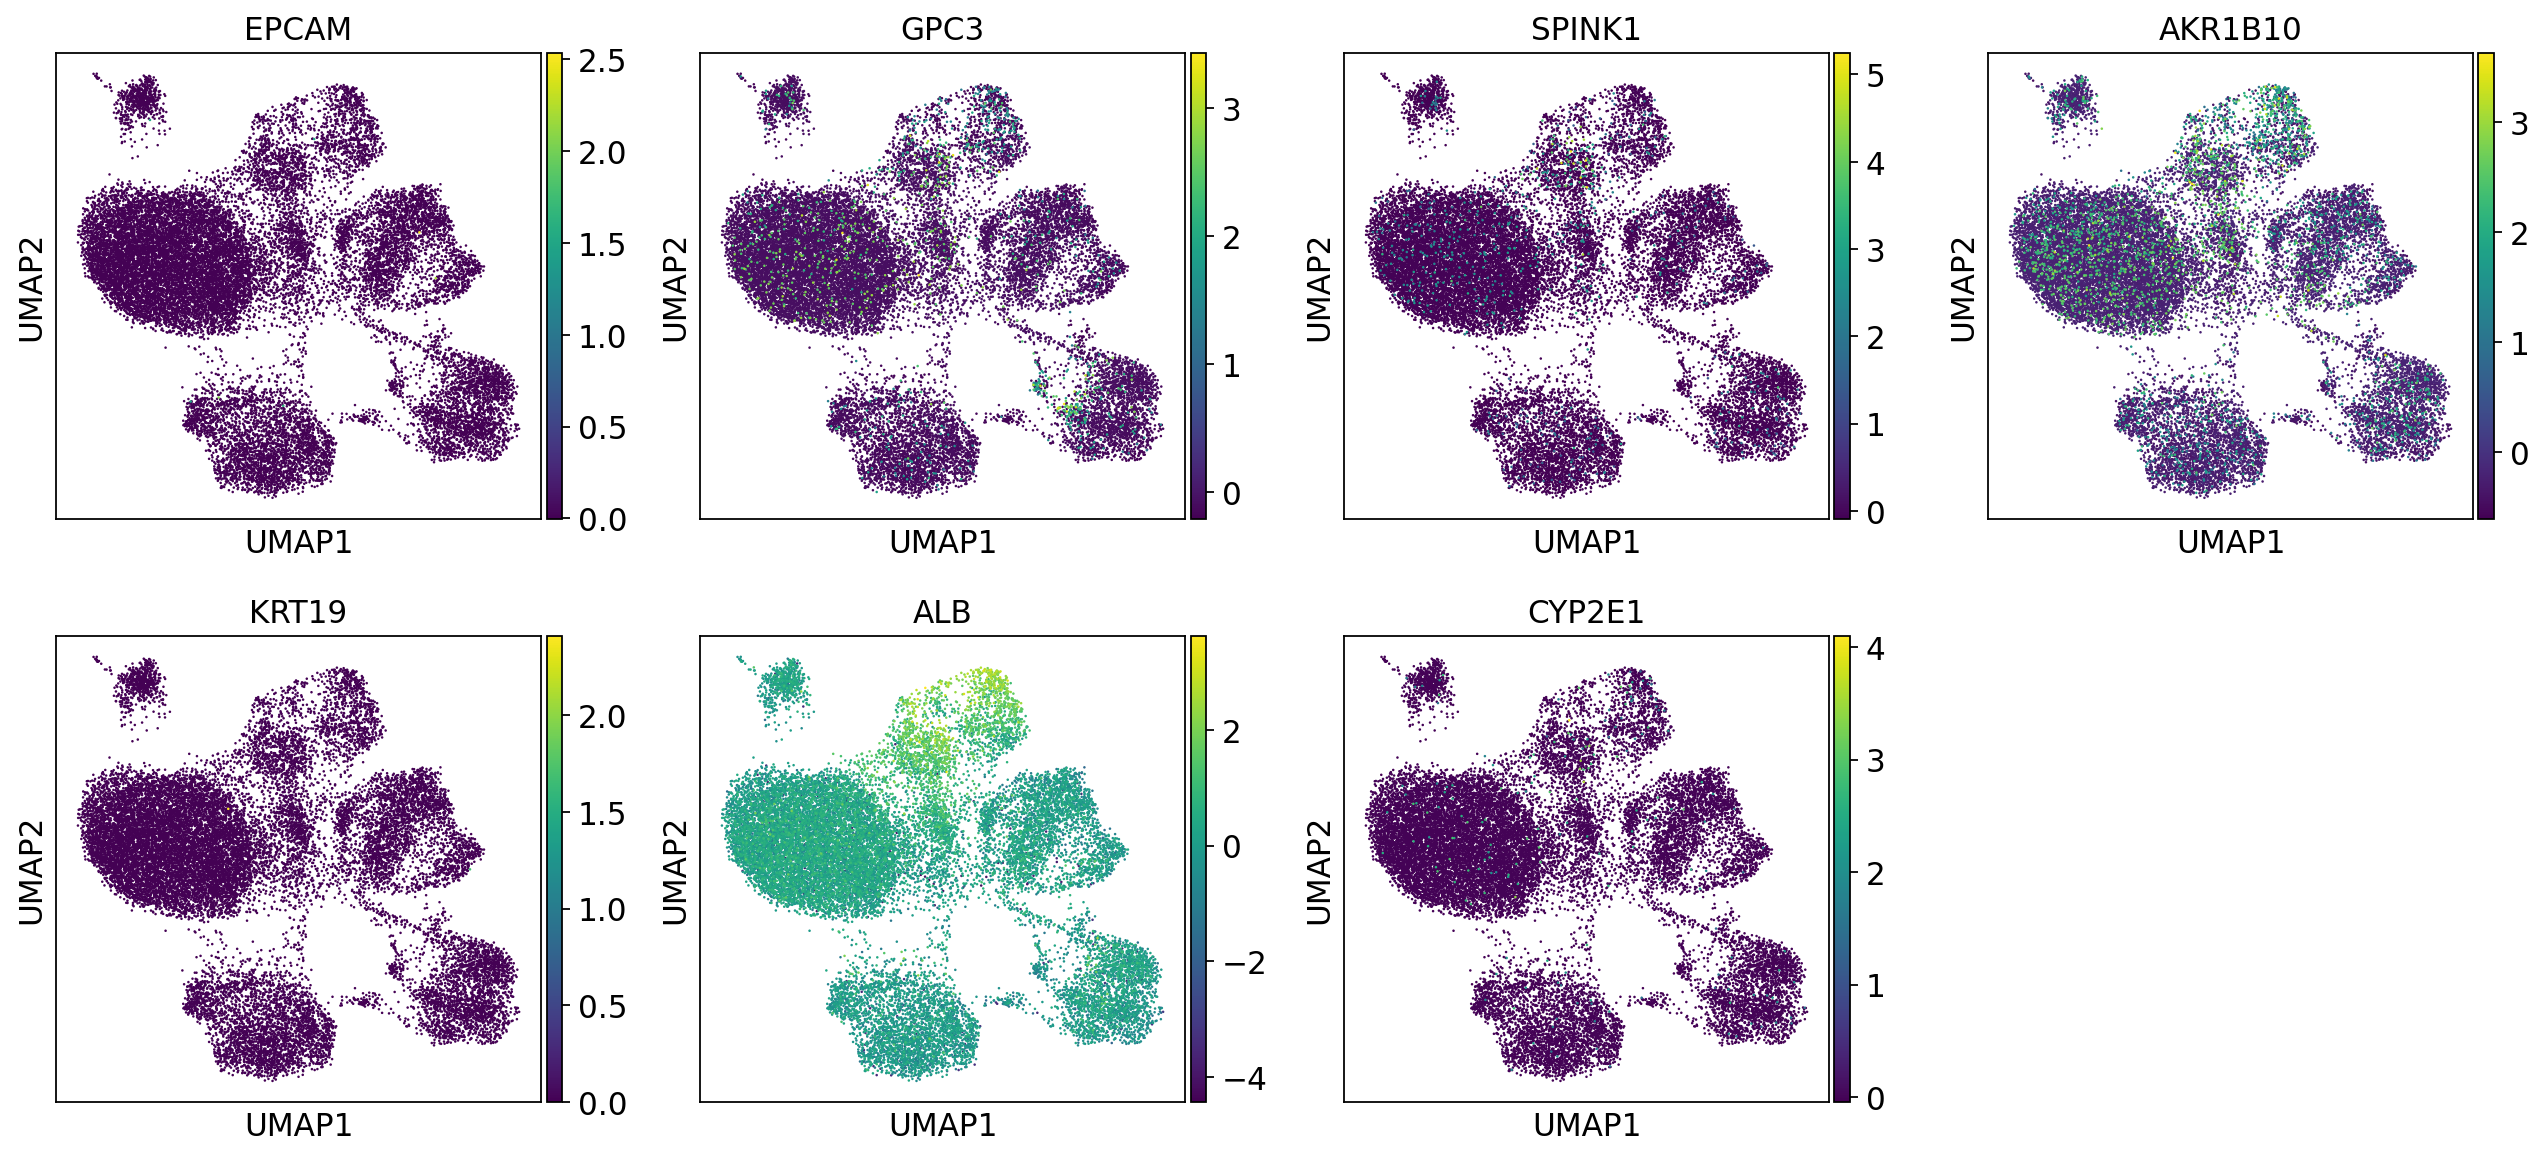

./SingleCell/20200208-PAC-CRR034505-T10-Tumor
... reading from cache file cache/SingleCell-20200208-PAC-CRR034505-T10-Tumor-filtered_feature_bc_matrix-matrix.h5ad
normalizing counts per cell
    finished (0:00:00)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


/home/glab/wguo/softwares/anaconda3/envs/rtest4-3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:37)
finish regressing...!!!
computing tSNE
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:17)
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:19)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
finish umap...!!!


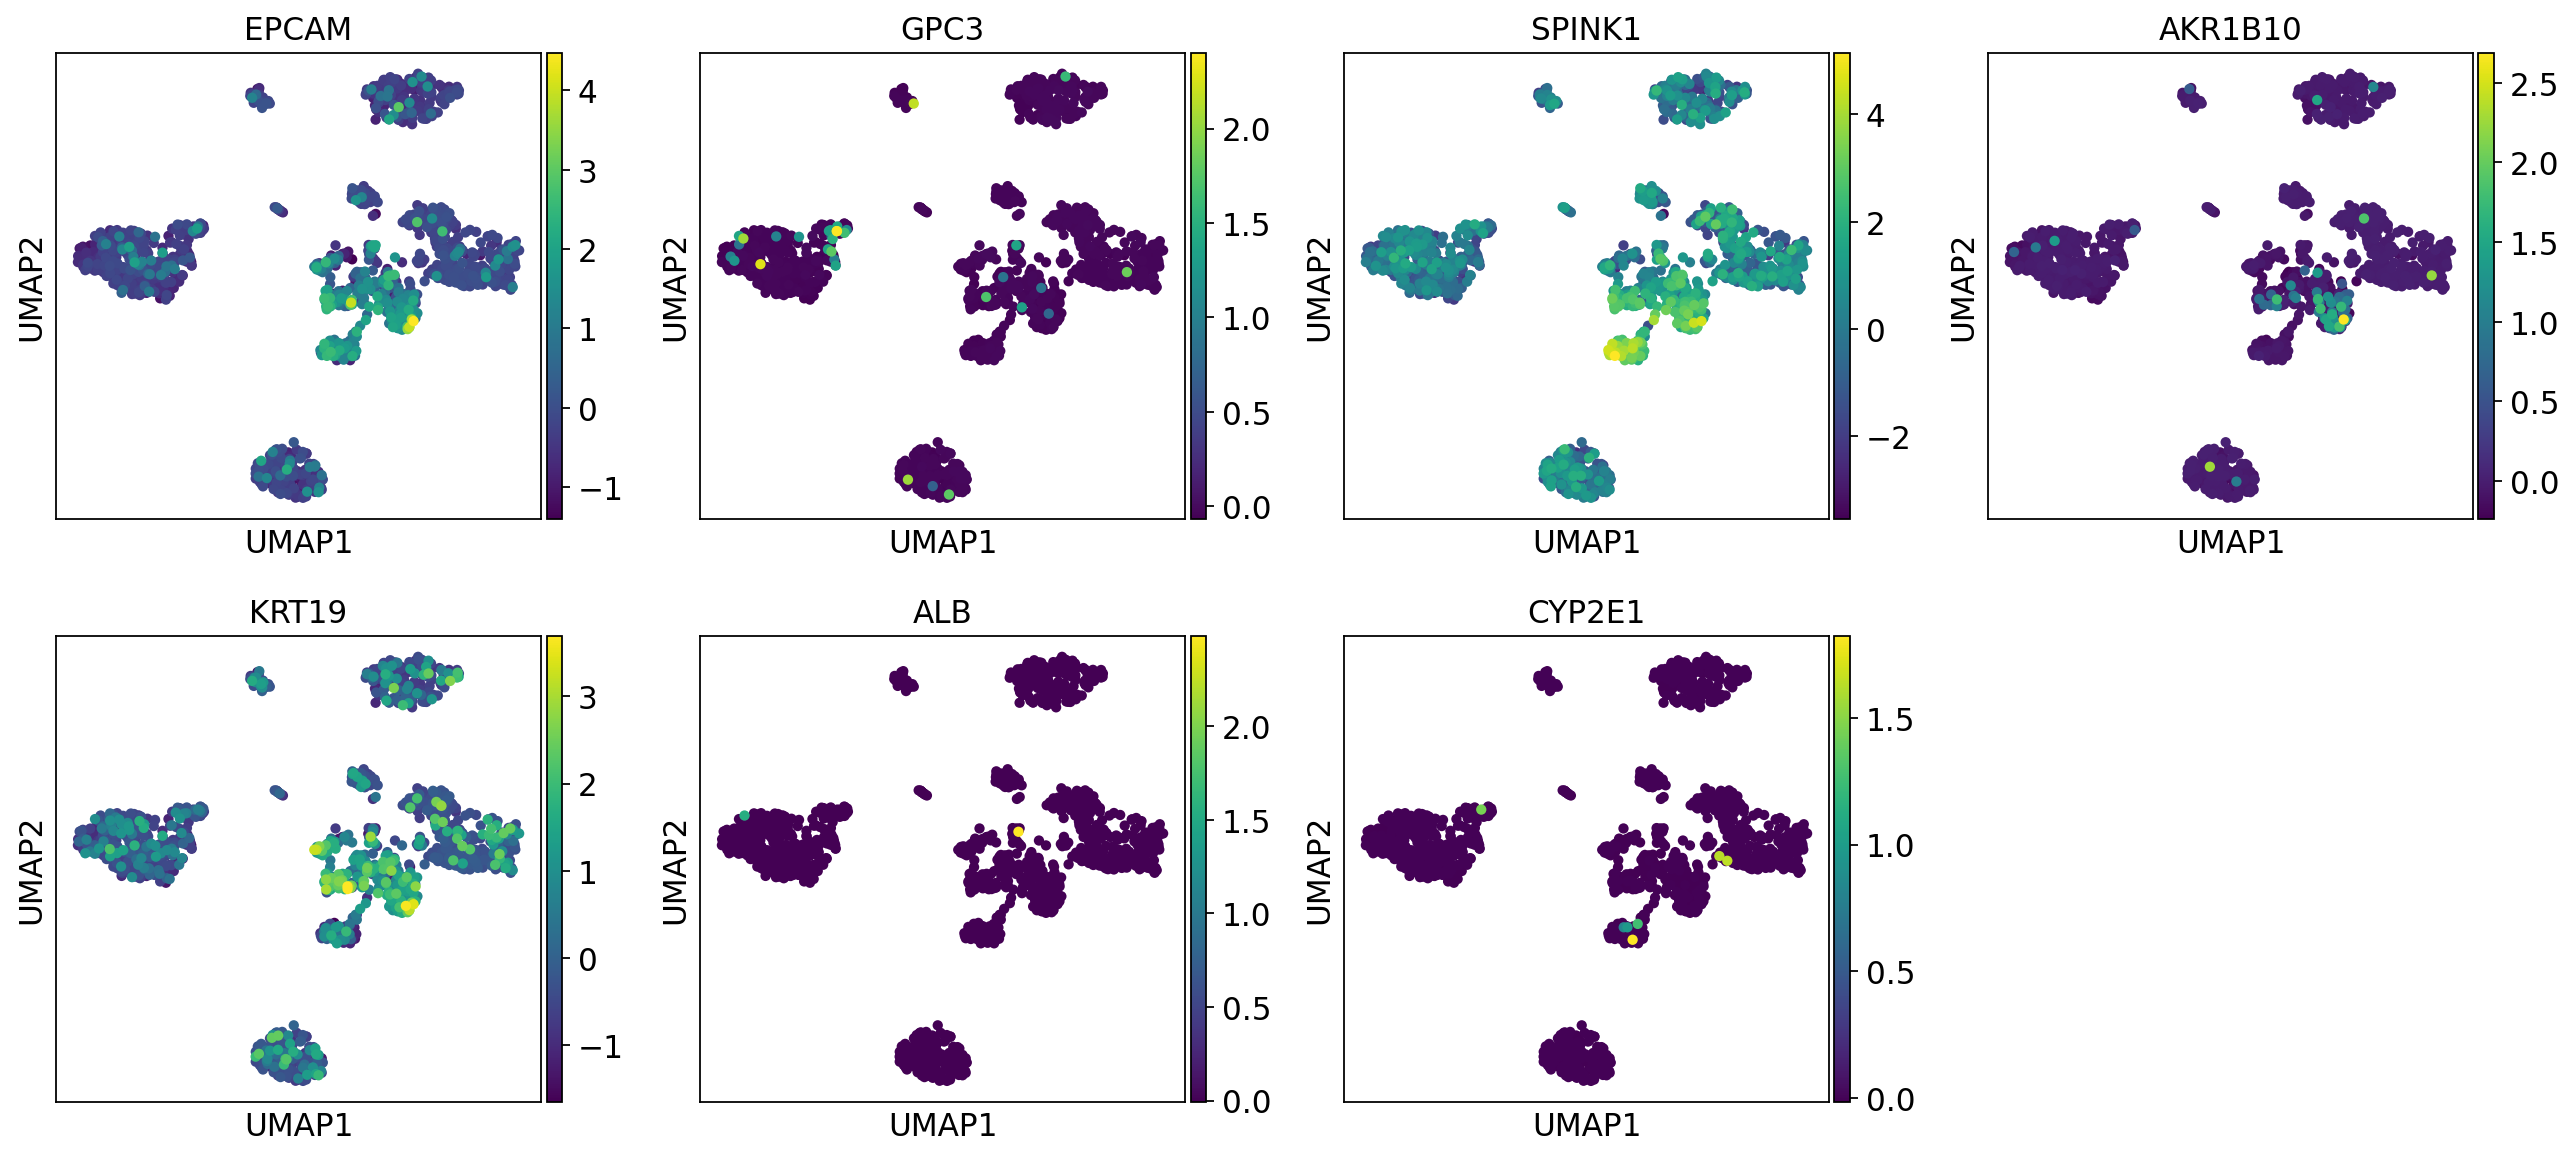

In [14]:
epthelial_markers = ['EPCAM', 'GPC3', 'SPINK1', 'AKR1B10', 'KRT19', 'ALB', 'CYP2E1']
# Samples selected
names = ['20200217-LUAD-LX653-Tumor', '20200208-PAC-CRR034496-T1-Tumor', '20200215-HCC-Pt13c-Tumor',
         '20200217-LUAD-LX684-Tumor', '20200215-HCC-Pt14d-Tumor','20200208-PAC-CRR034505-T10-Tumor']
for name in names:
    path = './SingleCell/' + name
    print(path)
    data = sc.read_10x_mtx(path+'/filtered_feature_bc_matrix', var_names='gene_symbols', cache=True)
    cellAnn = pd.read_csv(path +'/cellAnnotation.txt', delim_whitespace=True, 
                          usecols=['barcodes','UMAP_1', 'UMAP_2', 'Malign.type', 'Epithelial.corr', 'Cell.Type'],
                          index_col=['barcodes'])
    data.var_names_make_unique()
    # 基础过滤:去除表达基因200以下的细胞, 去除在3个细胞以下表达的基因。
    # sc.pp.filter_cells(data, min_genes=200)
    # sc.pp.filter_genes(data, min_cells=3)
    # 过滤线粒体基因比例 > 15% 的细胞
    mito_genes = data.var_names.str.startswith('MT-')
    data.obs['percent_mito'] = np.sum(data[:,mito_genes].X,axis=1).A1 / np.sum(data.X,axis=1).A1
    data.obs['n_counts'] = data.X.sum(axis=1).A1
    mitoThres = 0.15
    # data = data[data.obs.percent_mito < mitoThres, :]
    data = data[cellAnn.index + '-1',]
    # 标准化:TPM
    sc.pp.normalize_total(data, target_sum=1e4)
    sc.pp.log1p(data)
    sc.pp.regress_out(data, ['n_counts', 'percent_mito']) # 校正细胞基因计数和线粒体基因比例的影响。
    print("finish regressing...!!!")
    sc.tl.tsne(data)
    sc.pp.neighbors(data)
    sc.tl.umap(data)
    # path = './SingleCell/' + predictSample
    # cellAnn = pd.read_csv(path+'/cellAnnotation.txt', delim_whitespace=True, 
    #                     usecols=['barcodes','tSNE_1','tSNE_2'], index_col=['barcodes'])
    # decomp_data = pd.merge(arr, cellAnn, how='inner', left_index=True, right_index=True)
    # predict = reg.predict(decomp_data.iloc[:,:-2])
    # decomp_data = decomp_data.loc[:,['tSNE_1','tSNE_2']]
    print("finish umap...!!!")
    sc.pl.umap(data, color=epthelial_markers)